# Tutorial: Basics of LIGO Data and Signal Processing

We will be looking at applying some of the signal processing techniques learned earlier on real LIGO data here using a few Python libraries.

In particular, to access public LIGO data hosted via GWOSC, we will be using the `requests` library to access files directly via HTTP and in a later session we will use the `gwosc` library directly to access LIGO timeseries data. For common signal processing techniques used within LIGO, we will be using `gwpy`. We have seen `numpy` and `matplotlib` previously, which will be used for plotting and to generate periodic data.

### Import some packages

In [65]:
import os
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy
from gwpy.plot import Plot
from gwpy.timeseries import TimeSeries

### Query and download data file

Here, we will be making an HTTP request to GWOSC with the `requests` library with a specific URL requested. Later on, we will see how to use the `gwosc` library directly to determine which URLs are relevant for a given event.

Here, we will access 32 seconds of LIGO data and look at the data in various ways before and after applying signal processing techniques.

In [66]:
url = "https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170729/v1/H-H1_GWOSC_4KHZ_R1-1185389792-32.hdf5"
t0 = 1185389808

filename = os.path.basename(url)
# -- only download if strain data hasn't already been downloaded
if not os.path.exists(filename):
    print('Downloading: ' , url)

    with open(filename, 'wb') as strainfile:                 
        straindata = requests.get(url)
        strainfile.write(straindata.content)

### Plot the raw time-series data

Now, we will be using `gwpy` to read in the LIGO data file containing the strain time series and plot a random 1 second segment of the raw strain time series.

The `TimeSeries` object is a convenient way of representing and manipulating time series data. It is able to read in data formats commonly used within LIGO as well by calling `TimeSeries.read()` with the filename of the file (`filename`) as well as the format of the file expected (`hdf5.losc`).

If we print the results of `TimeSeries.read()`, we can see several properties defined, such as the start time of the timeseries `t0` and the spacing between adjacent points `dt`. The sampling rate of the timeseries is 1 / dt.

For more information on the `TimeSeries` object in `gwpy`, see: https://gwpy.github.io/docs/stable/timeseries/index.html#the-timeseries.

In [67]:
# -- Read strain data
strain = TimeSeries.read(filename, format='hdf5.losc')
print(strain)

TimeSeries([-3.36397949e-19, -2.31521541e-19, -4.51137019e-20,
            ...,  7.38163644e-19,  6.82927750e-19,
             5.54931259e-19]
           unit: dimensionless,
           t0: 1185389792.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


We have 32 seconds of LIGO data available in a variable called `strain`. We can plot a 1 second subset of this data by calling `crop()` with the start and end time and plot the results with `plot()`.

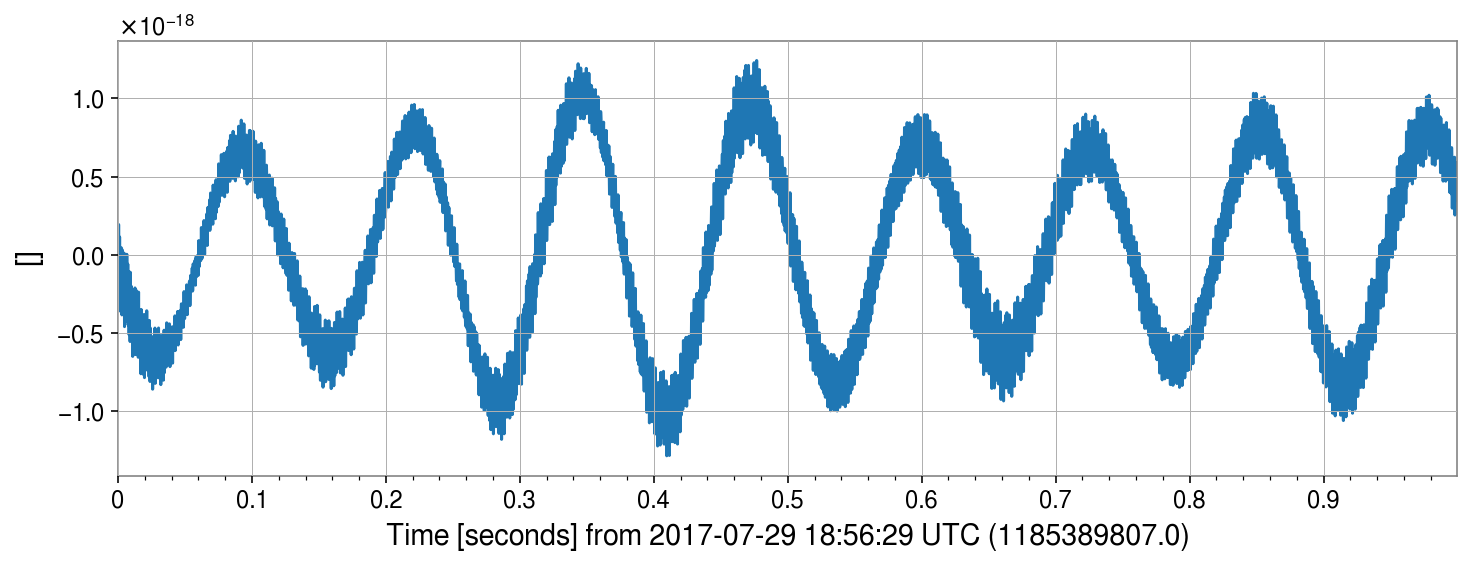

In [68]:
# -- Plot raw strain data
cropped = strain.crop(t0-1, t0)
fig1 = cropped.plot()

We can see highly periodic data with a frequency of about 8 Hz (count the number of peaks in this 1 second segment of data).

### Plot the ASD

Now, let's plot the Amplitude Spectral Density (ASD) estimate of the data. We can do that with `gwpy` with `asd()` with a specified FFT length. Recall that calculating the ASD requires a Fourier transform, and a length of data to define the Fast Fourier Transform (FFT) is required. It is typically a power of two, and here we set it to be 8 seconds. 

(1e-24, 1e-18)

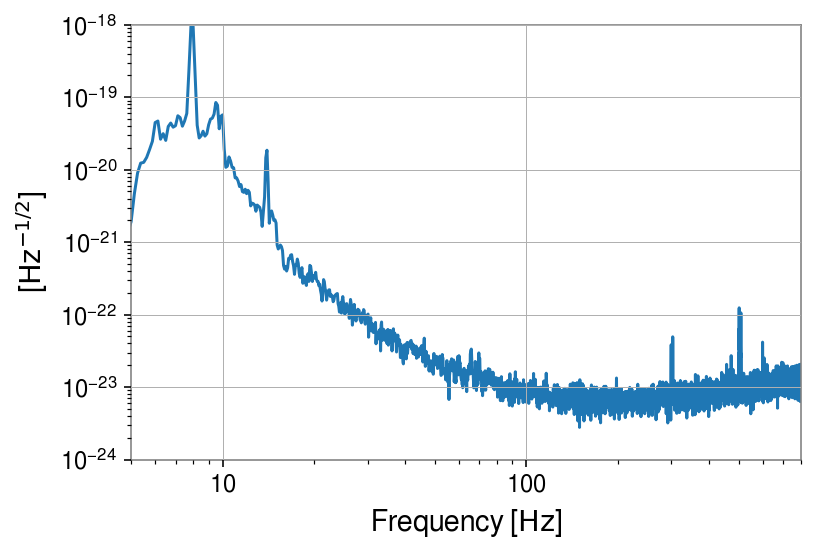

In [69]:
# -- Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(5, 800)
plt.ylim(1e-24, 1e-18)

Here we can see that the dominant frequency is around 8 Hz which explains how the data is dominated by this periodic component. It also matches roughly to the guesstimate of the frequency of the periodic component.

### High pass the data

We can start to apply signal processing techniques to change how the data looks by low-passing, high-passing, or band-passing the data. Let's remove this low frequency periodic noise by high passing the data at 10 Hz, or alternatively, only keeping noise components with frequencies above 10 Hz, and look at the timeseries and the ASD.

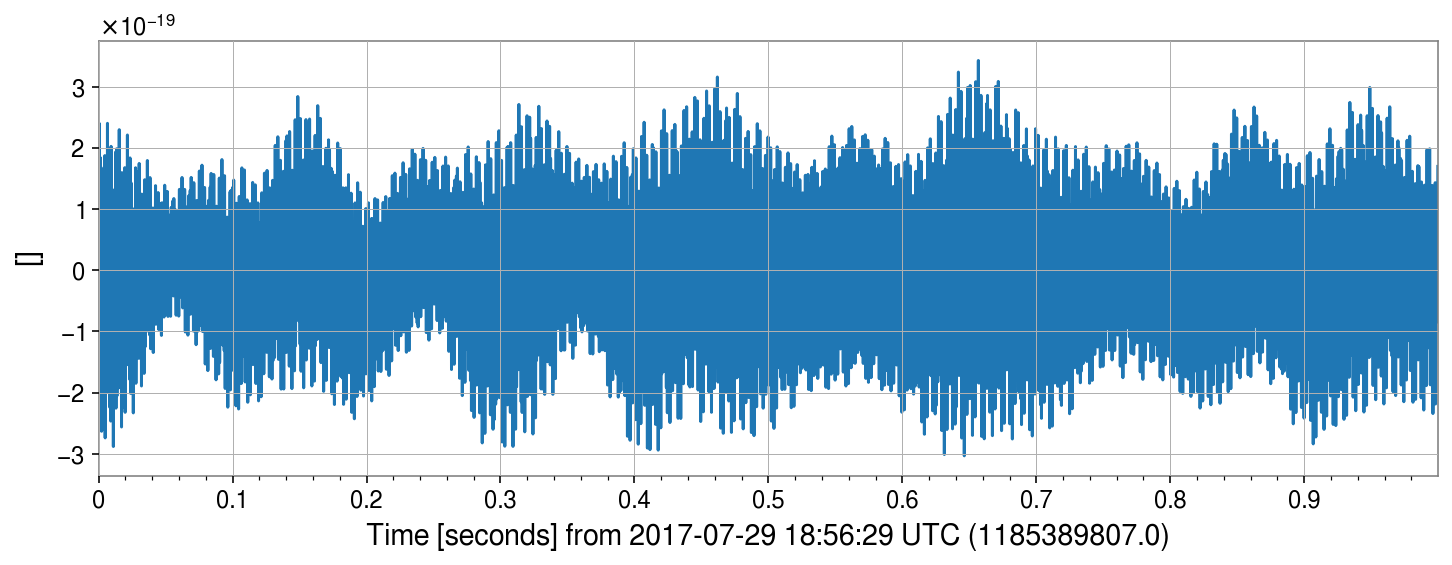

In [70]:
# -- High pass the data
highpassed = strain.highpass(10)
fig3 = highpassed.crop(t0-1, t0).plot()

(1e-24, 1e-18)

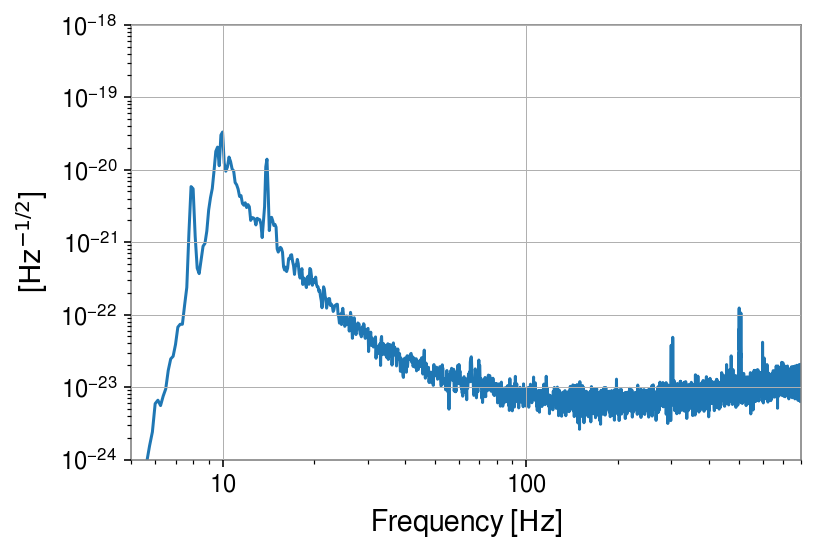

In [71]:
# -- Plot ASD
fig4 = highpassed.asd(fftlength=8).plot()
plt.xlim(5, 800)
plt.ylim(1e-24, 1e-18)

We can see that the highly periodic component is gone and most of the power below 10 Hz has been removed. You can see in the ASD that the low-pass procedure is not perfect and it does not remove all of the noise, especially as we get closer to the high-pass cutoff frequency of 10 Hz.

### Creating periodic data

Let's create some simulated periodic data to inject into the LIGO data earlier at a frequency of 30 Hz. We can generate periodic data with `numpy` and inject this periodic data into the strain data with `gwpy`.

The form for a sinusoidal wave we will be using to generate our periodic data is in the form:

$A \sin(2 \pi f t)$

where

$A = $ Amplitude of sine wave

$f = $ Frequency of sine wave

$t = $ time.

Then once we create our data with `numpy`, we can create a `TimeSeries` by passing in this data, the start time `t0` and the spacing between time points `dt` which is inversely related to the sampling rate.

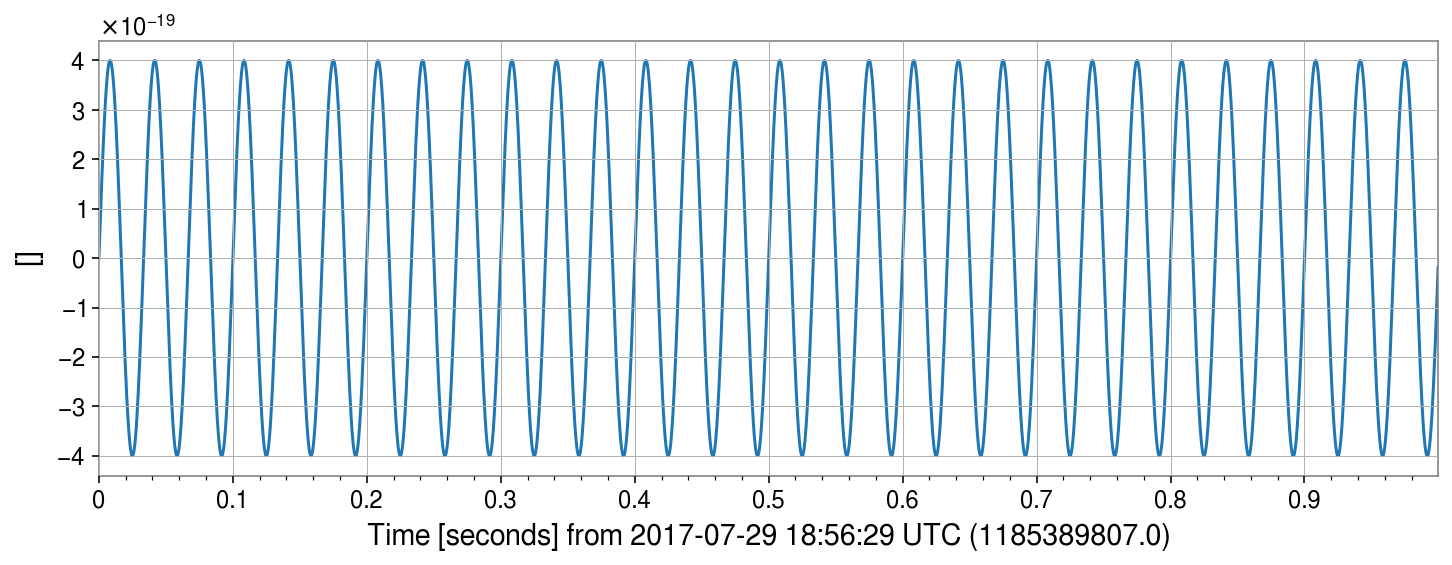

In [72]:
# -- Create periodic data
t_start = 1185389792
duration = 32
sample_rate = 4096
dt = 1. / sample_rate
f = 30
amplitude = 4 * 10 ** -19

t_data = numpy.arange(sample_rate * duration, dtype=float) / sample_rate
periodic_data = amplitude * numpy.sin(t_data * 2 * numpy.pi * f)

periodic = TimeSeries(periodic_data, t0=t_start, dt=dt)
fig5 = periodic.crop(t0-1, t0).plot()

(1e-24, 1e-18)

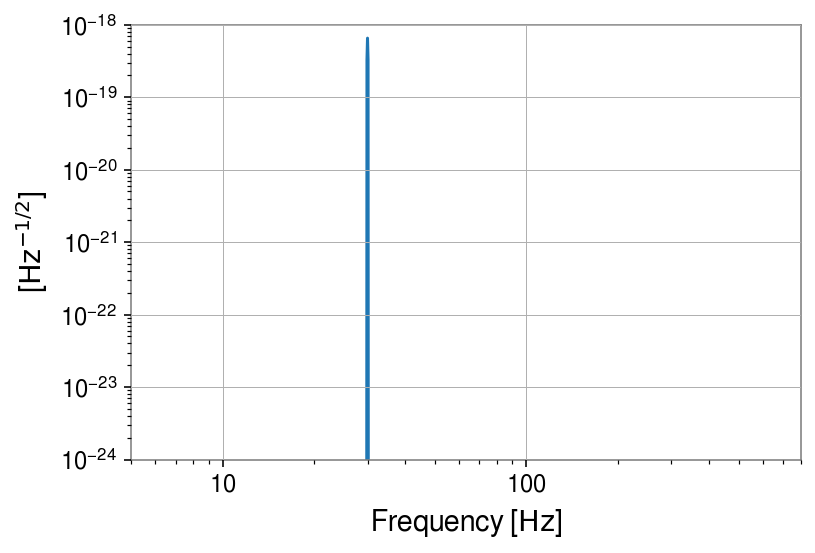

In [73]:
# -- Plot ASD
fig6 = periodic.asd(fftlength=8).plot()
plt.xlim(5, 800)
plt.ylim(1e-24, 1e-18)

Looking at the ASD of this data, it has a single peak at the frequency of the sine wave at 30 Hz. Now, let's inject (or add) this data into the high-passed strain data from earlier:

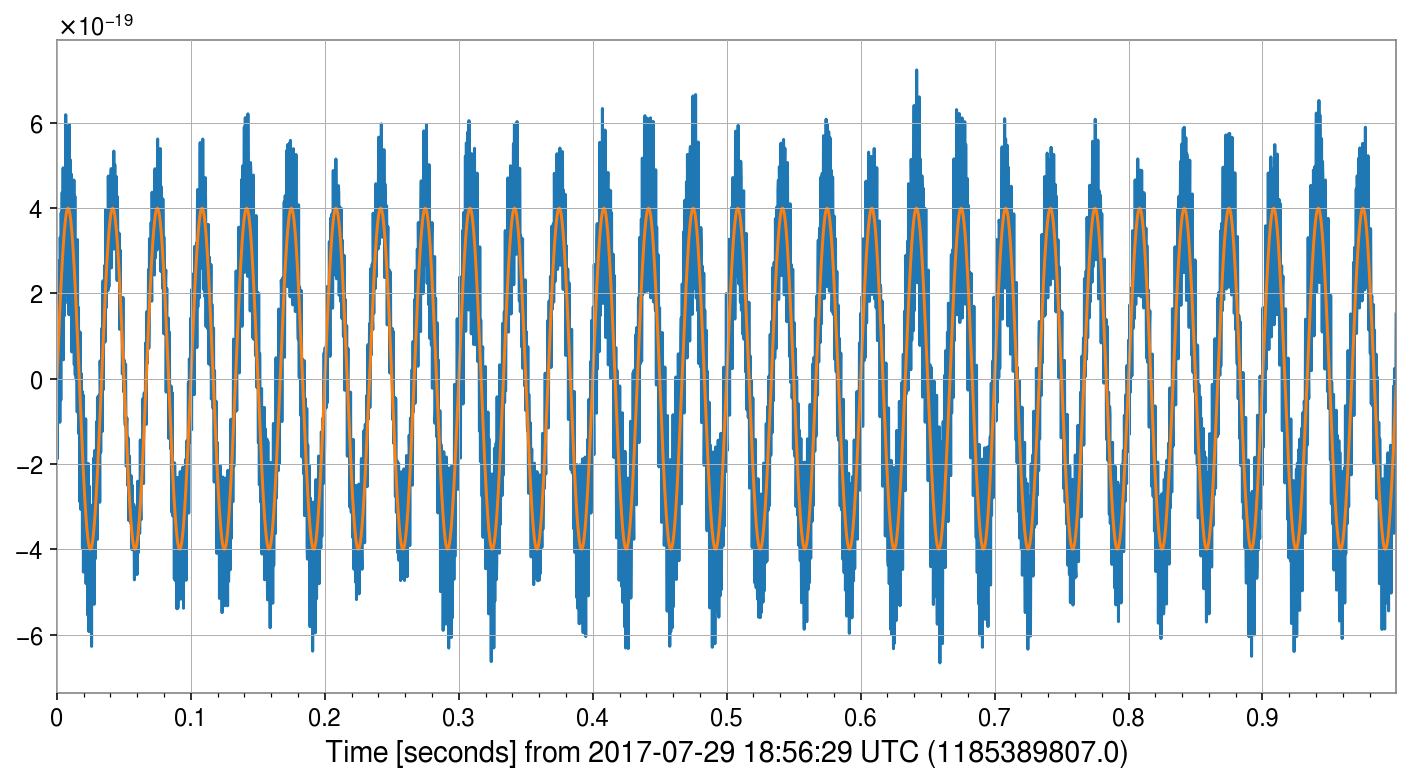

In [74]:
# -- Add periodic data to high-passed strain data
added = highpassed.inject(periodic)
fig7 = Plot(added.crop(t0-1, t0), periodic.crop(t0-1, t0)).show()

(1e-24, 1e-18)

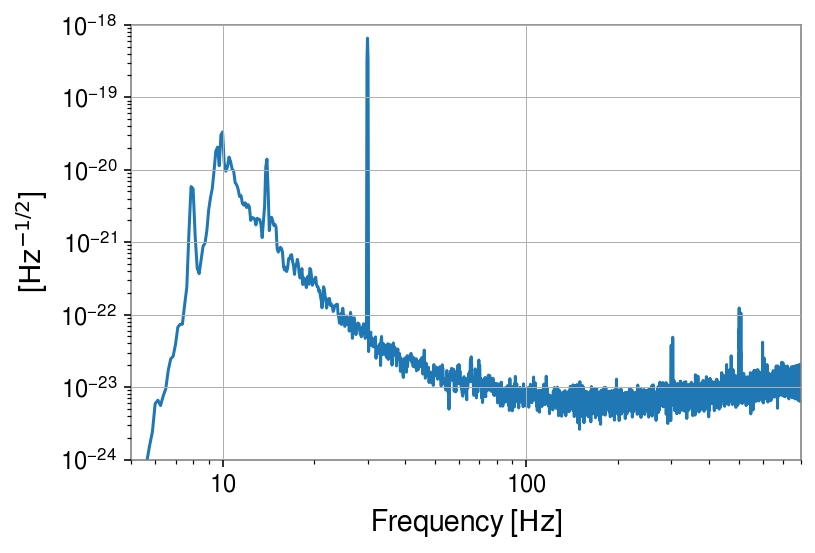

In [75]:
# -- Plot ASD
fig8 = added.asd(fftlength=8).plot()
plt.xlim(5, 800)
plt.ylim(1e-24, 1e-18)

### View a time-frequency representation of the data

Now let's look at a time-frequency representation, or spectrogram of the data we just generated. Typically for LIGO data, we look at a specific type of representation with a Q transform. The details are not important, except that it emphasizes particular regions of the frequency space which make it easier to interpret the data. This is similar in concept to different world map projections (e.g. Mercator) which can emphasize or de-emphasize different regions of the image in question.

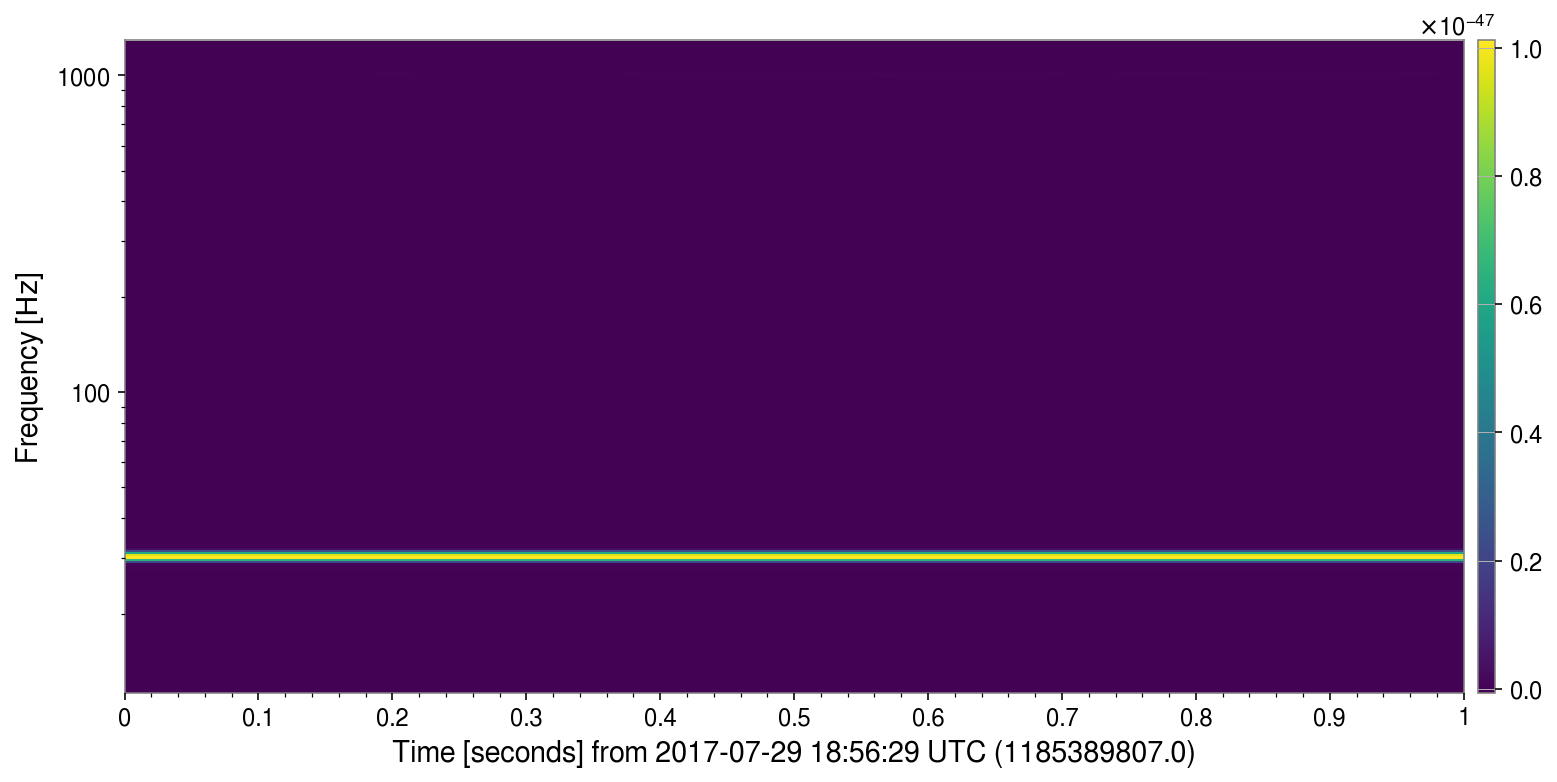

In [76]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = added.q_transform(outseg=(t0-1., t0), whiten=False, norm=False)
fig9 = hq.plot()
ax = fig9.gca()
fig9.colorbar()
ax.grid(False)
ax.set_yscale('log')

Here we can see periodic noise at 30 Hz which dominates the noise spectrum and is constant over time.